In [1]:
import numpy as np
import torch
from torch import nn

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

In [2]:
import torchvision
from torchvision import models
from torchvision import transforms
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torchvision import models
from tqdm.auto import tqdm
torch.manual_seed(0)

# tensor -> PIL image
unloader = transforms.ToPILImage()

In [3]:
class ToyDataset(Dataset):
    def __init__(self, dark_img_dir, light_img_dir):
        self.dark_img_dir = dark_img_dir
        self.light_img_dir = light_img_dir
        self.n_dark = len(os.listdir(self.dark_img_dir))
        self.n_light = len(os.listdir(self.light_img_dir))

    def __len__(self):     
        return min(self.n_dark, self.n_light)

    def __getitem__(self, idx):
        
        filename = os.listdir(self.light_img_dir)[idx]
        
        light_img_path = f"{self.light_img_dir}{filename}"
        light = Image.open(light_img_path).convert("RGB")
        
        dark_img_path = f"{self.dark_img_dir}{filename}"
        dark = Image.open(dark_img_path).convert("RGB")        
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        light = transform(light)
        dark = transform(dark)         

        return dark, light

batch_size = 1
    
train_dark_dir = f"./data_augment/train/dark/"
train_light_dir = f"./data_augment/train/light/"
training_set = ToyDataset(train_dark_dir,train_light_dir)
training_generator = DataLoader(training_set, batch_size=batch_size)

val_dark_dir = f"./data_augment/test/dark/"
val_light_dir = f"./data_augment/test/light/"
validation_set = ToyDataset(val_dark_dir, val_light_dir)
validation_generator = DataLoader(validation_set, batch_size=batch_size)

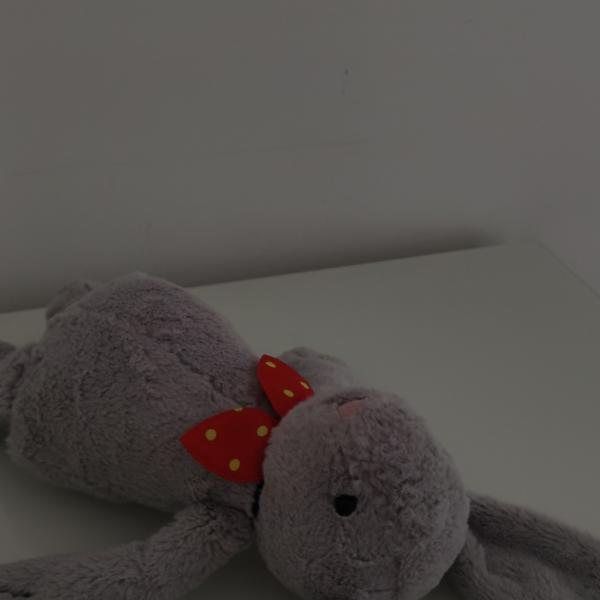

In [4]:
for idx,(dark, light) in enumerate(training_generator):
    if idx == 50:
        break
unloader(dark[0,])

In [5]:
dark.shape

torch.Size([1, 3, 600, 600])

### U-Net Code

In [6]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels.
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - round(new_shape[2] / 2)
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - round(new_shape[3] / 2)
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x
    
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x],1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)
    

### PatchGAN Discriminator

The discriminator outputs a one-channel matrix of classifications instead of a single value.

In [7]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y],1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

## Training Preparation

  *   **real_dim**: the number of channels of the real image and the number expected in the output image
  *   **adv_criterion**: an adversarial loss function to keep track of how well the GAN is fooling the discriminator and how well the discriminator is catching the GAN
  *   **recon_criterion**: a loss function that rewards similar images to the ground truth, which "reconstruct" the image
  *   **lambda_recon**: a parameter for how heavily the reconstruction loss should be weighed
  *   **n_epochs**: the number of times you iterate through the entire dataset when training
  *   **input_dim**: the number of channels of the input image
  *   **display_step**: how often to display/visualize the images
  *   **batch_size**: the number of images per forward/backward pass
  *   **lr**: the learning rate
  *   **target_shape**: the size of the output image (in pixels)
  *   **device**: the device type

In [ ]:
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 20
input_dim = 3
real_dim = 3
display_step = 200
batch_size = 4
lr = 0.0002
target_shape = 256



In [ ]:
gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


In [ ]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. maps) to be used to evaluate the reconstruction
        condition: the source images (e.g. satellite imagery) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the true labels and returns a adversarial 
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator 
                    outputs and the real images and returns a reconstructuion 
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    # Steps: 1) Generate the fake images, based on the conditions.
    #        2) Evaluate the fake images and the condition with the discriminator.
    #        3) Calculate the adversarial and reconstruction losses.
    #        4) Add the two losses, weighting the reconstruction loss appropriately.
    fake = gen(condition)
    dis = disc(fake, condition)
    adv_loss = adv_criterion(dis, torch.ones_like(dis))
    recon_loss = recon_criterion(fake, real)
    gen_loss = adv_loss + lambda_recon * recon_loss
    return gen_loss

In [ ]:
# UNIT TEST
def test_gen_reasonable(num_images=10):
    gen = torch.zeros_like
    disc = lambda x, y: torch.ones(len(x), 1)
    real = None
    condition = torch.ones(num_images, 3, 10, 10)
    adv_criterion = torch.mul
    recon_criterion = lambda x, y: torch.tensor(0)
    lambda_recon = 0
    assert get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon).sum() == num_images

    disc = lambda x, y: torch.zeros(len(x), 1)
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon)).sum() == 0

    adv_criterion = lambda x, y: torch.tensor(0)
    recon_criterion = lambda x, y: torch.abs(x - y).max()
    real = torch.randn(num_images, 3, 10, 10)
    lambda_recon = 2
    gen = lambda x: real + 1
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 2) < 1e-4

    adv_criterion = lambda x, y: (x + y).max() + x.max()
    assert torch.abs(get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon) - 3) < 1e-4
test_gen_reasonable()
print("Success!")